q-1-4.py

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import tree, preprocessing
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
eps = np.finfo(float).eps

from pylab import *
import matplotlib
import matplotlib.pyplot as plt


Reading data from csv

In [3]:
df = pd.read_csv('train.csv')

spliting features and class label and dropping numerical data.

In [4]:
Y = df.left
X = df.drop(['left'],axis='columns')

doing One hot Encoding to convert multi-valued features to binary.

In [5]:
# axis = 0 means row and axis= 1 means columns. 
# default is 0. 
Z = pd.concat([X,pd.get_dummies(X['sales'], prefix='sales')],axis='columns')
Z = pd.concat([Z,pd.get_dummies(Z['salary'], prefix='salary')],axis='columns')
Z = Z.drop(['sales','salary'],axis='columns')

Split train and test data 

In [6]:
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.2)
X_train, X_test, Y_train, Y_test = train_test_split(Z, Y,test_size=0.2)
X_test_copy = X_test.copy(deep=True)
df1 = pd.concat([X_train,Y_train],axis=1)

Plotting data for features : satisfaction_level and last_evaluation

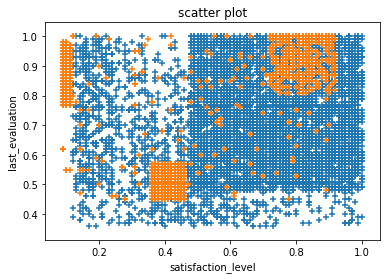

In [14]:
X_train0 = df1[ df1['left'] == 0]
X_train1 = df1[ df1['left'] == 1]

figure()

scatter(X_train0['satisfaction_level'],X_train0['last_evaluation'],marker='+' )
scatter(X_train1['satisfaction_level'],X_train1['last_evaluation'],marker='+')

xlabel('satisfaction_level')
ylabel('last_evaluation')
title('scatter plot')

show()

finding entropy of class label

In [6]:
def get_entropy( df ):
    Class = df.keys()[-1]
    entropy = 0
    values = df[Class].unique()
    for value in values:
        fraction = float(df[Class].value_counts()[value])/len(df[Class])
        entropy += -fraction*np.log2(fraction+eps)
    return entropy

#TESTING OF ENTROPY FUNC
# c = pd.DataFrame({'rushit' : [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,11,1,1,1,1,1,1,1,1,1,1]})
# x_ent = get_entropy(c.rushit)
# x_ent

finding entropy of given attribute

In [7]:
def get_entropy_attr( df,  attribute ):
    Class = df.keys()[-1]
    target_variables = df[Class].unique()  
    variables = df[attribute].unique()
    entropy2 = 0
    for variable in variables:
        entropy = 0
        for target_variable in target_variables:
            num = len(df[attribute][df[attribute]==variable][df[Class] ==target_variable])
            den = len(df[attribute][df[attribute]==variable])
            fraction = num/(den+eps)
            entropy += -fraction*np.log2(fraction+eps)
        fraction2 = float(den)/len(df)
        entropy2 += -fraction2*entropy
    return abs(entropy2)

selecting attribute with highest information gain

In [8]:
def attr_to_select(df):
    Entropy_att = []
    IG = []
    for key in df.keys()[:-1]:
        IG.append(get_entropy(df)-get_entropy_attr(df,key))
    return df.keys()[:-1][np.argmax(IG)]

dividing table in subtable by given value and attribute.

In [9]:
def get_subtable(df, node, value):
    return df[df[node] == value].reset_index(drop=True)

finding information gain by splitting value of attr at splitting point val.

In [10]:
class_ent = get_entropy(df1)
def find_IG( df, val, attr ):
    left = df[df[attr] < val ].reset_index(drop=True)
    right = df[df[attr] >= val ].reset_index(drop=True)
    left_ent = get_entropy(left)
    right_ent = get_entropy(right)
    return class_ent - ((float(len(left))/(len(df)+eps) * left_ent)+( float(len(right))/(len(df)+eps) * right_ent))

finding maximum split point by trying all possibilities

In [11]:
def split_numerical( attr , Y , attr_name):
    max_ig = 0
    max_split = None
    pair = pd.concat([attr, Y], axis='columns')
    pair = pair.sort_values(by =attr_name).reset_index()
    for i in xrange( len(attr)-1):
#         print i, pair[attr_name][i] , pair[attr_name][i+1]
        if pair['left'][i] != pair['left'][i+1]:
            cur_ig = find_IG( pair, float(pair[attr_name][i] + pair[attr_name][i+1])/2 , attr_name )
            if cur_ig > max_ig:
                max_ig = cur_ig
                max_split =  float(pair[attr_name][i] + pair[attr_name][i+1])/2
    return max_split

changing data in actual dataframe

In [12]:
def change_actual( df, val, attr ):
    df.loc[df[attr] < val, attr ] = 0
    df.loc[df[attr] >= val, attr ] = 1
    return

getting dictionary of splitting points

In [13]:
num_attr = [ 'number_project','last_evaluation', 'satisfaction_level','average_montly_hours','time_spend_company']
split_dict = {}
for attr in num_attr:
    split_val = split_numerical(df1[attr], df1['left'],attr)
    split_dict[attr] = split_val
print split_dict

{'satisfaction_level': 0.46499999999999997, 'last_evaluation': 0.58, 'average_montly_hours': 274.5, 'time_spend_company': 3.0, 'number_project': 2.5}


preprocessing data with numerical features

In [14]:
def preprocess(df,split_dict):
    for key,value in split_dict.iteritems():
        change_actual(df, value, key)

preprocess(df1,split_dict)

Tree node structures

In [15]:
class Node:
    def __init__(self, feature):
        self.feature = feature
        self.positive = 0
        self.negative = 0
        self.left = None
        self.right = None

Building Tree

In [16]:
def build_Tree(df):
    if len(df.columns) == 1:
        return None
    node_to_split = attr_to_select(df)
    
    root = Node(node_to_split)
    root.positive = len( df[df['left']==1]['left'] )
    root.negative = len( df[df['left']==0]['left'] )
    
    subtable0 = get_subtable(df,node_to_split,0)
    subtable1 = get_subtable(df,node_to_split,1)
    
    subtable0 = subtable0.drop(node_to_split,axis=1)
    subtable1 = subtable1.drop(node_to_split,axis=1)
    
    clValue0,counts0 = np.unique(subtable0['left'],return_counts=True)
    clValue1,counts1 = np.unique(subtable1['left'],return_counts=True)
        
    if len(counts0)>1:
        root.left = build_Tree(subtable0)
    if len(counts1)>1:
        root.right = build_Tree(subtable1)
    
    return root

Prediction od data

In [17]:
def rec_predict(df,root,Y1):
    if root == None:
        return None
    try:
        if root.right==None and root.left==None:
            Y1.append(1 if root.positive > root.negative else 0)
            return

        if root.right==None and df[root.feature] == 1:
            Y1.append(1 if root.positive > root.negative else 0)
            return 
        if root.left == None and df[root.feature] == 0:
            Y1.append(1 if root.positive > root.negative else 0)
            return
        
        if df[root.feature]==0:
            rec_predict(df,root.left,Y1)
        else:
            rec_predict(df,root.right,Y1)
    except KeyError:
        if root.left == None:
            Y1.append(1 if root.positive > root.negative else 0)
            return
        rec_predict(df,root.left,Y1)
        
def predict(df,root,Y1):
    for col,row in df.iterrows():
        rec_predict(row,root,Y1)

Our Model

In [18]:
root = build_Tree(df1)

In [19]:
pd.options.mode.chained_assignment = None

Yp=[]
preprocess(X_test,split_dict)
predict(X_test,root,Yp)

print confusion_matrix(Y_test,Yp)
print classification_report(Y_test,Yp)
print accuracy_score(Y_test, Yp)

[[1681   35]
 [ 219  313]]
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      1716
           1       0.90      0.59      0.71       532

   micro avg       0.89      0.89      0.89      2248
   macro avg       0.89      0.78      0.82      2248
weighted avg       0.89      0.89      0.88      2248

0.8870106761565836


Inbuilt scikit learn model

In [20]:
model = tree.DecisionTreeClassifier()
model.fit(X_train, Y_train)
Y_predict = model.predict(X_test_copy)
print confusion_matrix(Y_test,Y_predict)
print classification_report(Y_test,Y_predict)
print accuracy_score(Y_test, Y_predict)

[[1676   40]
 [  30  502]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1716
           1       0.93      0.94      0.93       532

   micro avg       0.97      0.97      0.97      2248
   macro avg       0.95      0.96      0.96      2248
weighted avg       0.97      0.97      0.97      2248

0.9688612099644128


Testing on sample_test.csv

In [21]:
test_df = pd.read_csv('sample_test.csv')

Z_test = pd.concat([test_df,pd.get_dummies(test_df['sales'], prefix='sales')],axis='columns')
Z_test = pd.concat([Z_test,pd.get_dummies(Z_test['salary'], prefix='salary')],axis='columns')
Z_test = Z_test.drop(['sales','salary'],axis='columns')

preprocess(Z_test, split_dict)
Out = []
predict(Z_test, root, Out)
print Out

[0, 1]
